In [ ]:
pip install -q pytorchvideo transformers evaluate decord transformers datasets

In [ ]:
pip install accelerate==0.27.2

# Video classification

In [ ]:
full_data_path = "/content/drive/MyDrive/final_video_dataset_yolov8"
train_test_split_data_path = "challenge_dataset/"

Notebook includes:
1. Fine-tune [VideoMAE](https://huggingface.co/docs/transformers/main/en/model_doc/videomae) on **[Machathon](https://drive.google.com/drive/folders/1LbV_sHKRhJ1LYq-UUmPkFgM-MEp9qURO)**
and **[Shoplifting Dataset (2022) - CV Laboratory MNNIT Allahabad](https://data.mendeley.com/datasets/r3yjf35hzr/2)** datasets.
2. Useing the fine-tuned model for inference.

[PyTorchVideo](https://pytorchvideo.org/) (dubbed `pytorchvideo`) is used to process and prepare the videos.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load the Segmented dataset

At a high level, the dataset is organized like so:

```bash
final_video_dataset_yolov8/
    train/
        0_no_lifting/
            video_1.mp4
            video_2.mp4
            ...
        1_lifting/
            video_1.mp4
            video_2.mp4
            ...
        ...
    val/
        0_no_lifting/
            video_1.mp4
            video_2.mp4
            ...
        1_lifting/
            video_1.mp4
            video_2.mp4
            ...
        ...
    test/
        0_no_lifting/
            video_1.mp4
            video_2.mp4
            ...
        1_lifting/
            video_1.mp4
            video_2.mp4
            ...
        ...
```

Next up, we derive the set of labels present in the dataset. Also, create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_video_file_paths = "/content/drive/MyDrive/final_test_data"

In [ ]:
import os

In [ ]:
os.listdir(all_video_file_paths)

['0_no_lifting', '1_lifting']

In [ ]:
class_labels = sorted({path for path in os.listdir(all_video_file_paths)})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['0_no_lifting', '1_lifting'].


## Load a model to fine-tune

Instantiate a video classification model from a pretrained checkpoint and its associated image processor. The model's encoder comes with pre-trained parameters, and the classification head is randomly initialized. The image processor will come in handy when writing the preprocessing pipeline for our dataset.

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

# pretrained model name
model_ckpt = "MCG-NJU/videomae-base-finetuned-kinetics"
# pretrained configurations
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
# pretrained model
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

## Prepare the datasets for training

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
    AugMix,
    CutMix,
    RandAugment,
    Permute

)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomHorizontalFlip,
    Resize,

)

For the training dataset transformations, use a combination of uniform temporal subsampling, and pixel normalization. For the validation and evaluation dataset transformations, keep the same transformation.

`image_processor` is used associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.


In [ ]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30

In [ ]:
clip_duration = 20

Defining the dataset-specific transformations and the datasets respectively. Starting with the training set:

In [ ]:
dataset_root_path = "/content/drive/MyDrive/challenge_dataset"

In [ ]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

train_dataset = pytorchvideo.data.Ucf101(
    data_path="/content/drive/MyDrive/final_test_data",
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

The same sequence of workflow can be applied to the validation and evaluation sets:

In [ ]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

**Note**: We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it folloes a similar structure.
You can access the `num_videos` argument to know the number of videos in the dataset.

In [ ]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

347 20 20


## Visualize the preprocessed video for better debugging

In [ ]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


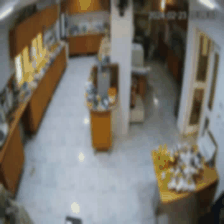

In [ ]:
sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

## Train the model

Leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. Instantiate a `Trainer`, you need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training.

Most of the training arguments are self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in this case, you need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [ ]:
import accelerate
import torch
import random

In [ ]:
accelerate.__version__

'0.27.2'

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}_m_v11"
num_epochs = 5
batch_size = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

The dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__` method. As such, we must define `max_steps` when instantiating `TrainingArguments`.

Next, you need to define a function to compute the metrics from the predictions, which will use the `metric` you'll load now. The only preprocessing you have to do is to take the argmax of our predicted logits:

In [ ]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

Also, define a `collate_fn`, which will be used to batch examples together. Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then you just pass all of this along with the datasets to `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

You might wonder why you passed along the `image_processor` as a tokenizer when you preprocessed the data already. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the Hub.

Now fine-tune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.001000,0.006368,1.000000
1,0.000100,0.367884,0.900000


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch,Training Loss,Validation Loss,Accuracy
0,0.001000,0.006368,1.000000
1,0.000100,0.367884,0.900000
2,0.053700,0.000941,1.000000


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: 

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mena55/videomae-base-finetuned-kinetics_m_v11/commit/2a3179c79ecb7760a5583eb037bbaf755428095f', commit_message='End of training', commit_description='', oid='2a3179c79ecb7760a5583eb037bbaf755428095f', pr_url=None, pr_revision=None, pr_num=None)

## Inference

You can also manually replicate the results of the `pipeline` if you'd like.

In [ ]:
def run_inference(model, video):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),

    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        print(outputs)
        logits = outputs.logits

    return logits

Now, pass your input to the model and return the `logits`:

```
>>> logits = run_inference(trained_model, sample_test_video["video"])
```

Decoding the `logits`, we get:

In [ ]:
test_dataset = pytorchvideo.data.Ucf101(
    data_path="new_test",
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
predicted = []
correct = []

for vid in test_dataset:
    logits = run_inference(model, vid["video"])
    predicted_class_idx = logits.argmax(-1).item()
    predicted.append(predicted_class_idx)
    correct.append(vid["label"])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Compute accuracy
accuracy = accuracy_score(correct, predicted)

# Compute precision
precision = precision_score(correct, predicted)

# Compute recall
recall = recall_score(correct, predicted)

# Compute F1 score
f1 = f1_score(correct, predicted)

In [ ]:
# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
import transformers

In [ ]:
transformers.__version__

In [ ]:
import pytorchvideo

In [ ]:
pytorchvideo.__version__